## Load data

In [1]:
PATH = "../../../data/EIA/fuel_type_data_california.parquet"

In [2]:
import pandas as pd
df = pd.read_parquet(PATH)

df

,period,respondent,respondent-name,fueltype,type-name,value,value-units
0,2025-04-22 20:00:00-07:00,CAL,California,BAT,Battery storage,179,megawatthours
1,2025-04-22 20:00:00-07:00,CAL,California,COL,Coal,216,megawatthours
...,...,...,...,...,...,...,...
452546,2018-12-31 17:00:00-07:00,CAL,California,WAT,Hydro,2880,megawatthours
452547,2018-12-31 17:00:00-07:00,CAL,California,WND,Wind,2628,megawatthours


## Preprocess data

### Datetime column object

In [3]:
COLUMN_DATETIME = "period"

x = pd.to_datetime(df[COLUMN_DATETIME], utc=True)
x

0        2025-04-23 03:00:00+00:00
1        2025-04-23 03:00:00+00:00
                    ...           
452546   2019-01-01 00:00:00+00:00
452547   2019-01-01 00:00:00+00:00
Name: period, Length: 452548, dtype: datetime64[us, UTC]

In [4]:
df[COLUMN_DATETIME] = x

### Local timezones

In [5]:
TIMEZONE = 'America/Los_Angeles'

x = df[COLUMN_DATETIME]

try:
    x = x.dt.tz_convert(TIMEZONE)
except Exception as e:
    print(e)

x

0        2025-04-22 20:00:00-07:00
1        2025-04-22 20:00:00-07:00
                    ...           
452546   2018-12-31 16:00:00-08:00
452547   2018-12-31 16:00:00-08:00
Name: period, Length: 452548, dtype: datetime64[us, America/Los_Angeles]

In [6]:
df[COLUMN_DATETIME] = x

### Available series inside dataset

In [7]:
COLUMN_CATEGORIES = ['respondent', 'respondent-name', 'fueltype', 'type-name']

df[COLUMN_CATEGORIES].drop_duplicates().style

,respondent,respondent-name,fueltype,type-name
0,CAL,California,BAT,Battery storage
1,CAL,California,COL,Coal
2,CAL,California,GEO,Geothermal
3,CAL,California,NG,Natural Gas
4,CAL,California,NUC,Nuclear
5,CAL,California,OIL,Petroleum
6,CAL,California,OTH,Other
7,CAL,California,PS,Pumped storage
8,CAL,California,SNB,Solar with integrated battery storage
9,CAL,California,SUN,Solar


### Set index

The index is composed by the columns that uniquely identify the rows. The datetime column must be present.

In [8]:
COLUMN_CATEGORIES = ['respondent-name', 'type-name']

idx = COLUMN_CATEGORIES + [COLUMN_DATETIME]
x = df.set_index(idx).sort_index()

x

respondent fueltype  \
respondent-name type-name       period                                          
California      Battery storage 2025-01-01 01:00:00-08:00        CAL      BAT   
                                2025-01-01 02:00:00-08:00        CAL      BAT   
...                                                              ...      ...   
                Wind            2025-04-22 19:00:00-07:00        CAL      WND   
                                2025-04-22 20:00:00-07:00        CAL      WND   

                                                           value  \
respondent-name type-name       period                             
California      Battery storage 2025-01-01 01:00:00-08:00     11   
                                2025-01-01 02:00:00-08:00     -1   
...                                                          ...   
                Wind            2025-04-22 19:00:00-07:00   3419   
                                2025-04-22 20:00:00-07:00   3464   

                                                             value-units  
respondent-name type-name       period                                    
California      Battery storage 2025-01-01 01:00:00-08:00  megawatthours  
                                2025-01-01 02:00:00-08:00  megawatthours  
...                                                                  ...  
                Wind            2025-04-22 19:00:00-07:00  megawatthours  
                                2025-04-22 20:00:00-07:00  megawatthours  

[452548 rows x 4 columns]

In [9]:
x.index.is_unique

True

In [10]:
df = x.copy()

### Select values column

In [11]:
COLUMN_VALUES = "value"

x = df[COLUMN_VALUES]
x

respondent-name  type-name        period                   
California       Battery storage  2025-01-01 01:00:00-08:00      11
                                  2025-01-01 02:00:00-08:00      -1
                                                               ... 
                 Wind             2025-04-22 19:00:00-07:00    3419
                                  2025-04-22 20:00:00-07:00    3464
Name: value, Length: 452548, dtype: int64

plot = x.unstack(level=COLUMN_CATEGORIES).plot(figsize=(15, 8), linewidth=2, alpha=0.8)
plot.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plot.figure.tight_layout()

In [12]:
series = x.copy()

### Filter one time series

To get a table with the unique datetime index of the series, and the time series values.

<div class="alert alert-warning">
Not necessary if the data already represents a time series with unique datetime values.
</div>


In [13]:
CATEGORIES = ('California', 'Solar')

x = series.loc[CATEGORIES]
x

period
2018-12-31 16:00:00-08:00     1595
2018-12-31 17:00:00-08:00        8
                             ...  
2025-04-22 19:00:00-07:00    13293
2025-04-22 20:00:00-07:00     5113
Name: value, Length: 55300, dtype: int64

In [14]:

from modules import utils
utils.configure_plotly_template(showlegend=True)

In [15]:
x.plot()

In [16]:
series = x.copy()

### Aggregate

**Check if you need to aggregate your data:**

- ✅ **Keep as-is** if data is already at appropriate frequency (monthly, quarterly, etc.)
- 🔄 **Aggregate first** if data is too granular for your seasonal question:
  - **Annual seasonality** → Aggregate to monthly
  - **Weekly patterns** → Aggregate to daily  
  - **Daily patterns** → Aggregate to hourly

**Rule of Thumb:**

Match your data frequency to the seasonal cycle you want to study. Most seasonal business analysis works best with **monthly data** to capture yearly patterns.

**Note**: You need at least 3-5 complete seasonal cycles for reliable decomposition results.

In [17]:
RULE = '2W-MON'

x = series.resample(RULE).sum()
x

period
2018-12-31 00:00:00-08:00       1470
2019-01-14 00:00:00-08:00     650255
                              ...   
2025-04-14 00:00:00-07:00    2220059
2025-04-28 00:00:00-07:00    1391534
Freq: 2W-MON, Name: value, Length: 166, dtype: int64

In [ ]:
x.plot()

In [19]:
series = x.copy()

### Transform datetime index to standard format

In [20]:
x.index = x.index.tz_localize(None).astype("datetime64[ns]")
x.index.freq = RULE
x

period
2018-12-31       1470
2019-01-14     650255
               ...   
2025-04-14    2220059
2025-04-28    1391534
Freq: 2W-MON, Name: value, Length: 166, dtype: int64

In [21]:
series = x.copy()

### Filter datetime range

<div class="alert alert-warning">
Not necessary if you are interested in the whole time series. Although, it's advised to filter out outliers and incomplete data to get full periods, like full years, months, etc.
</div>

In [22]:
START, END = '2020', '2024'

In [23]:
x = series.loc[START:END]
x

period
2020-01-13     785589
2020-01-27     749438
               ...   
2024-12-09    1246879
2024-12-23    1152350
Freq: 2W-MON, Name: value, Length: 130, dtype: int64

In [24]:
x.plot()

In [25]:
series = x.copy()
df = series.to_frame(name='values')

df

,values
period,
2020-01-13,785589
2020-01-27,749438
...,...
2024-12-09,1246879
2024-12-23,1152350


## Data stationarity

### Data transformation

#### Constant variance

In [26]:
from statsmodels.tsa.stattools import adfuller
adfuller(df["values"])

(np.float64(-2.205738923138242),
 np.float64(0.20416915642045924),
 13,
 116,
 {'1%': np.float64(-3.4880216384691867),
  '5%': np.float64(-2.8867966864160075),
  '10%': np.float64(-2.5802408234244947)},
 np.float64(3111.813042319319))

In [27]:
import numpy as np

df["values_log"] = np.log(df["values"])
df = df.dropna()
df

,values,values_log
period,,
2020-01-13,785589,13.574189
2020-01-27,749438,13.527079
...,...,...
2024-12-09,1246879,14.036154
2024-12-23,1152350,13.957314


In [28]:
adfuller(df["values_log"])

(np.float64(-4.382540357637824),
 np.float64(0.0003186789076445752),
 11,
 118,
 {'1%': np.float64(-3.4870216863700767),
  '5%': np.float64(-2.8863625166643136),
  '10%': np.float64(-2.580009026141913)},
 np.float64(-157.7990130080483))

In [ ]:
fig = df.plot(facet_col="variable")
fig.update_yaxes(matches=None)
fig.update_layout()

In [30]:
PERIODS = 26

utils.plot_decomposition_comparison(df["values_log"], period=PERIODS)

#### Constant mean

In [31]:
df['values_log_diff'] = df['values_log'].diff().dropna()
df

,values,values_log,values_log_diff
period,,,
2020-01-13,785589,13.574189,NaN
2020-01-27,749438,13.527079,-0.047110
...,...,...,...
2024-12-09,1246879,14.036154,-0.128937
2024-12-23,1152350,13.957314,-0.078840


In [32]:
df = df.dropna()
df

,values,values_log,values_log_diff
period,,,
2020-01-27,749438,13.527079,-0.047110
2020-02-10,948090,13.762205,0.235126
...,...,...,...
2024-12-09,1246879,14.036154,-0.128937
2024-12-23,1152350,13.957314,-0.078840


In [33]:
fig = df.plot(facet_col="variable")
fig.update_yaxes(matches=None)
fig.update_layout()

In [34]:
adfuller(df["values_log_diff"])

(np.float64(-5.201841740611346),
 np.float64(8.71628200808484e-06),
 13,
 115,
 {'1%': np.float64(-3.4885349695076844),
  '5%': np.float64(-2.887019521656941),
  '10%': np.float64(-2.5803597920604915)},
 np.float64(-146.31738697122375))

## ACF & PACF


In [35]:
COLUMN_VALUES = "values_log_diff"

In [36]:
x = df[COLUMN_VALUES]
x

period
2020-01-27   -0.047110
2020-02-10    0.235126
                ...   
2024-12-09   -0.128937
2024-12-23   -0.078840
Freq: 2W-MON, Name: values_log_diff, Length: 129, dtype: float64

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

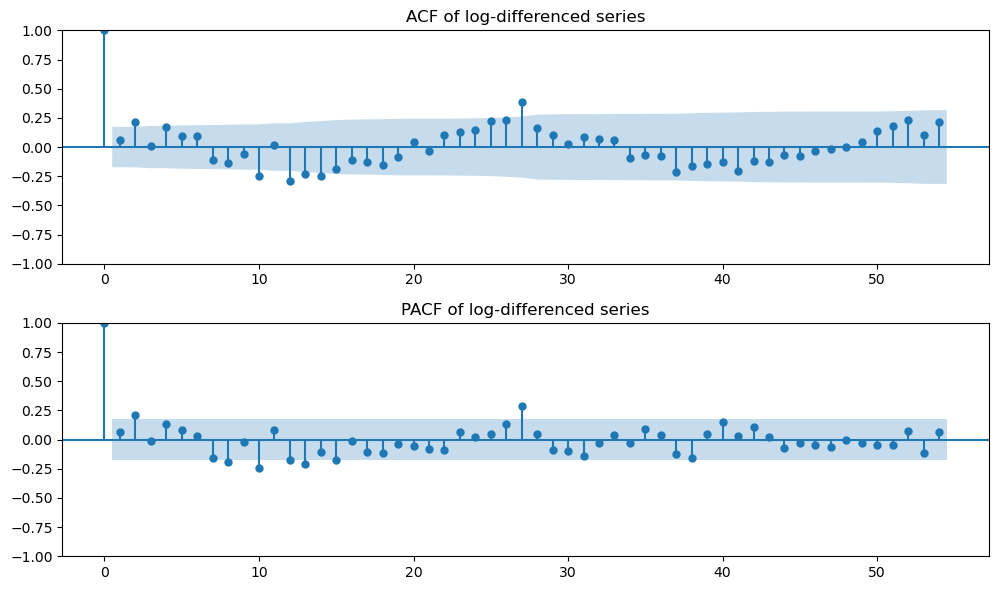

In [38]:
LAGS = 2.1 * PERIODS

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

plot_acf(x, ax=axes[0], lags=LAGS)
axes[0].set_title("ACF of log-differenced series")

plot_pacf(x, ax=axes[1], lags=LAGS)
axes[1].set_title("PACF of log-differenced series")

plt.tight_layout()
plt.show()

## Train test split

In [39]:
TEST_SIZE = PERIODS # 1 year

In [40]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(series, test_size=TEST_SIZE, shuffle=False)

## Variation playground

### Experiment configuration

In [41]:
from modules.utils import TimeSeriesForecaster

In [42]:
p, d, q = order = (0, 1, 1)
P, D, Q, s = seasonal_order = (0, 1, 1, PERIODS)

CONFIGS = {
    "sarima": {
        "model_params": {
            "order": order,
            "seasonal_order": seasonal_order,
            "enforce_invertibility": False,
            "enforce_stationarity": False,
        },
        "log_transform": True,
    },
    "ets": {
        "model_params": {
            "trend": "add",
            "seasonal": "mul",
            "damped_trend": False,
        },
        "log_transform": True,
    },
    "prophet": {
        "model_params": {
            "seasonality_mode": "multiplicative",
            "yearly_seasonality": True,
            "weekly_seasonality": True,
            "daily_seasonality": False,
            "changepoint_prior_scale": 0.5,
            "seasonality_prior_scale": 15.0,
        },
        "log_transform": True,
    },
}

In [43]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

METRICS = {
    'rmse': root_mean_squared_error,
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error,
}

### Run experiment with all models

In [44]:
idx_offset = d + D * s
idx_offset

27

In [45]:
from modules.utils import TimeSeriesForecaster

tf = TimeSeriesForecaster(train=train, test=test, freq=RULE, idx_offset=idx_offset)
df_forecast = tf.bulk_forecast(CONFIGS, metrics=METRICS)
df_forecast

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

21:23:04 - cmdstanpy - INFO - Chain [1] start processing
21:23:04 - cmdstanpy - INFO - Chain [1] done processing


,model,split,values,datetime,rmse,mae,mape
0,sarima,train,"[861327.7554901328, 1076132.5869044429, 118332...","DatetimeIndex(['2021-01-25', '2021-02-08', '20...",174958.839990,139736.284991,0.097489
1,sarima,test,"[1029431.0720980393, 1149554.5117564201, 14523...","DatetimeIndex(['2024-01-08', '2024-01-22', '20...",180750.893104,142841.525364,0.086162
...,...,...,...,...,...,...,...
4,prophet,train,"[895895.7867230327, 1107430.280942405, 1286361...","DatetimeIndex(['2021-01-25', '2021-02-08', '20...",86698.887653,73755.549852,0.053003
5,prophet,test,"[989790.796749877, 1080378.0982949284, 1327640...","DatetimeIndex(['2024-01-08', '2024-01-22', '20...",390475.220747,350754.777617,0.189732


## Choose best model

### Forecast plot

In [46]:
df_combined = tf.combine_with_historical(df_forecast)
df_combined

,model,split,datetime,values
0,ets,test,2024-01-08,1287506.29069
1,ets,test,2024-01-22,1315627.830093
...,...,...,...,...
410,historical,test,2024-12-09,1246879
411,historical,test,2024-12-23,1152350


In [47]:
import plotly.express as px

fig = px.line(
    data_frame=df_combined,
    x='datetime',
    y='values',
    color='model',
    facet_col='split',
    category_orders={'split': ['train', 'test']}
)

fig.update_xaxes(matches=None)

### Metrics review

In [48]:
dfm = df_forecast.melt(id_vars=["split", "model"], value_vars=["rmse", "mae", "mape"])
dfp = dfm.pivot(index=["split", "model"], columns="variable", values="value")
dfp.style.background_gradient(cmap="Greens_r", axis=0).format(precision=2)

## Diagnostics to validate assumptions

### Model fit

In [49]:
x = df["values"]
x

period
2020-01-27     749438
2020-02-10     948090
               ...   
2024-12-09    1246879
2024-12-23    1152350
Freq: 2W-MON, Name: values, Length: 129, dtype: int64

In [50]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p, d, q = order = (0, 1, 1)
P, D, Q, s = seasonal_order = (0, 1, 1, 12)

model = SARIMAX(x, order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

### Residuals

In [51]:
idx_offset = d + D * s

residuals = model_fit.resid[idx_offset:]
residuals

period
2020-07-27   -109350.950485
2020-08-10    -73744.227342
                  ...      
2024-12-09   -224720.902727
2024-12-23    -44269.684436
Freq: 2W-MON, Length: 116, dtype: float64

### Assumptions
#### Autocorrelation

##### Plot

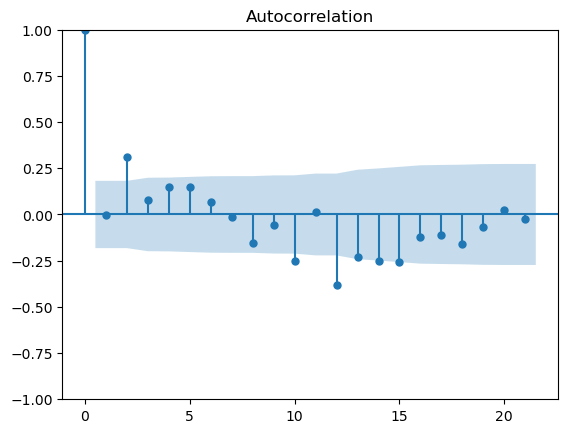

In [52]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals);

##### Test

In [53]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(residuals, lags=[10, 20, 30]).style

,lb_stat,lb_pvalue
10,29.727809,0.000949
20,81.692610,0.000000
30,127.995489,0.000000


#### Normality

##### Plot

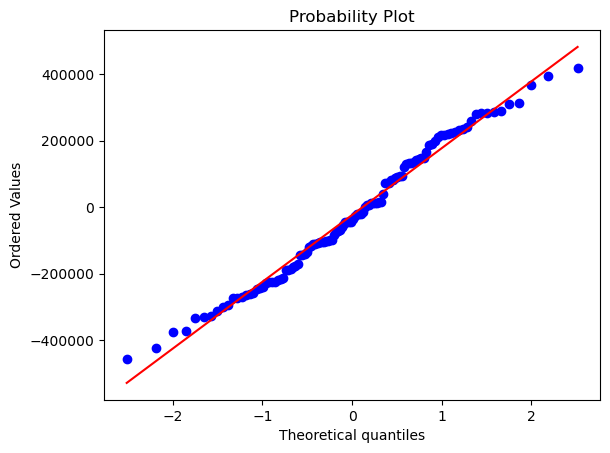

In [54]:
import matplotlib.pyplot as plt
from scipy import stats

fig, ax = plt.subplots()
stats.probplot(residuals, dist='norm', plot=ax);

##### Test

In [55]:
from scipy.stats import jarque_bera
jarque_bera(residuals)

SignificanceResult(statistic=np.float64(3.1922565691246323), pvalue=np.float64(0.20267971904763354))

#### Homoscedasticity

##### Plot

In [56]:
residuals.plot()

##### Test

In [57]:
from statsmodels.stats.diagnostic import het_arch
het_arch(residuals)

(np.float64(7.754619470869091),
 np.float64(0.6527912814236623),
 0.7498457899647778,
 0.6759852964387354)